In [1]:
import matplotlib.pyplot as plt
import matplotlib.image
import rasterio
import rasterio.plot
import rasterio.merge
import rasterio.mask
import geopandas as gpd
import cartopy.crs as ccrs
import numpy as np
import warnings
import time
import pandas as pd

In [2]:
import functions

### Start by loading in all the gauge data

In [3]:
daily_gauges = gpd.read_file("Gauge Data/Daily-Gauges-UK.shp",crs=4326)
hourly_gauges = gpd.read_file("Gauge Data/Hourly-Gauges-UK.shp",crs=4326)

#### Combine the two geo-dataframes (df)

In [4]:
gauges = hourly_gauges.append(daily_gauges)

C:\Users\david\AppData\Local\Temp\ipykernel_23924\4224330975.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gauges = hourly_gauges.append(daily_gauges)


### reading those into python and looping over it
In the command promt "dir /b > filenames.txt" generates a list of all the filenames in that directory<br>
[more info on commandpromt](https://www.thewindowsclub.com/how-to-open-command-prompt-from-right-click-menu#:~:text=To%20open%20a%20command%20prompt%20window%20in%20any%20folder%2C%20simply,the%20same%20inside%20any%20folder)<br>


In [5]:
filenames = []
with open("DEM data/filenames.txt") as fin:
    for line in fin:
        filenames.append(line.strip())
# filenames

#### Can loads in all the data we have
But takes long, dont do it. 

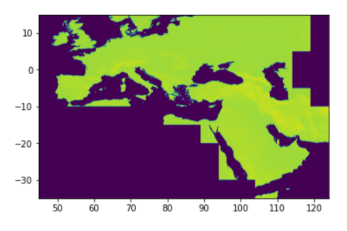

In [6]:
run = False
plot = False
if run:
    data = []
    for filepath in filenames:
        data.append(rasterio.open(f"DEM data/{filepath}/{filepath}/w001001.adf"))
if plot:
    rasterio.plot.show(data, transform=data.transform, title=f"{filepath}")

plt.imshow(matplotlib.image.imread("Figures/whole_data_set.png"))
plt.axis("off");

#### selecting just the parts we want

In [7]:
UK = filenames[68:69] + filenames[80:83] + filenames[95:97]
print(UK)

['n50e000_dem', 'n50w005_dem', 'n50w010_dem', 'n50w015_dem', 'n55w005_dem', 'n55w010_dem']


### first run over the data in the UK and load it in 

In [8]:
UK_data = []
UK_data_bounds = []
for filepath in UK:
    data = rasterio.open(f"DEM data/{filepath}/{filepath}/w001001.adf")
    UK_data.append(data)
    UK_data_bounds.append(data.bounds)
    if plot:
        # this would plot individually, more for debugging
        rasterio.plot.show(data, transform=data.transform, title=f"{filepath}")

#### As a check we can combine the data and plot it
Takes long and inefficient so lets not

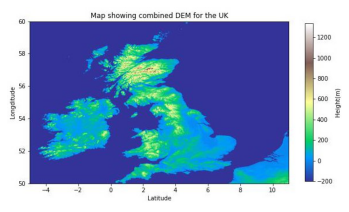

In [9]:
run = True
plot = False
if run:
    UK_total = rasterio.merge.merge(UK_data)
    if plot:
        rasterio.plot.show(UK_total[0], transform=imported_data.transform,cmap="viridis")
# Instead show image of already run data
plt.imshow(matplotlib.image.imread("Figures/whole of UK - cropped.jpg"))
plt.axis("off");

#### Let's compare the stations distribution and total land

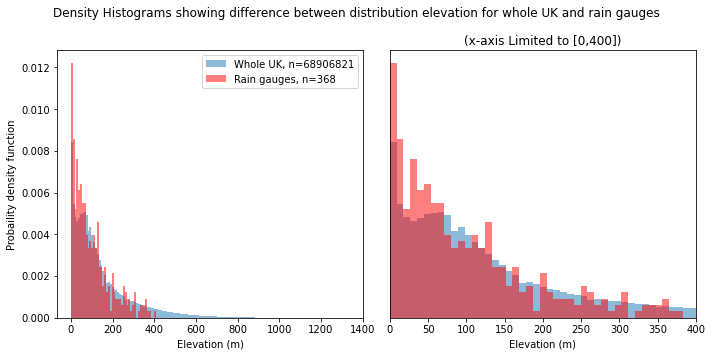

In [100]:
UK_total_1D = UK_total[0].flatten()
UK_total_1D = UK_total_1D[UK_total_1D > -1]

title = "Density Histograms showing difference between distribution elevation for whole UK and rain gauges"
fig, ax = plt.subplots(1,2, sharey=True, tight_layout=True, figsize=(10,5))
fig.suptitle(title)

for i in [0,1]:
    n, bins, patches = ax[i].axes.hist(UK_total_1D, bins = 150, density=True, alpha =0.5,
                                       label=f"Whole UK, n={len(UK_total_1D)}")
    ax[i].axes.hist(gauges.station_el.to_list(), bins = bins, density=True, alpha =0.5,
                    color="red",label=f"Rain gauges, n={len(gauges.station_el.to_list())}");
    ax[i].set_xlabel("Elevation (m)")
    

ax[0].legend()
ax[0].set_ylabel("Probaility density function")

ax[1].get_yaxis().set_visible(False)
ax[1].set_title("(x-axis Limited to [0,400])")
ax[1].set_xlim((0,400))
ax[1].figure.savefig(f"Figures/{title}.jpg");

In [64]:
max(UK_total_1D)

1335

#### We can then run code to match every gauge to the correct raster_id
(see functions for more detail on the code)

In [11]:
gauges["raster_id"] = functions.find_raster(gauges, UK_data_bounds)

#### Filter out gauges we dont want:
(99 is the 'not found' index)

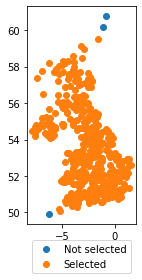

In [12]:
not_selected_gauges = gauges.query("raster_id == 99")
selected_gauges = gauges.query("raster_id != 99")
# can plot to verify
plot = True
if plot:
    ax = not_selected_gauges.plot(label="Not selected")
    selected_gauges.plot(ax=ax, label='Selected')
    plt.legend(bbox_to_anchor=(1, -0.05))

The Stations we're missing are only 3 and will be ignored for now
#### making a copy of the dataframe

In [13]:
gauges_circle = selected_gauges.copy()

#### then buffering: creating a circle around the rain gauge location to cut the data frame in half
and exporting it to be loaded in:

In [14]:
gauges_circle["geometry"] = gauges_circle["geometry"].buffer(0.025)
gauges_circle.to_file("circels with raster_id")

C:\Users\david\AppData\Local\Temp\ipykernel_23924\1142560235.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gauges_circle["geometry"] = gauges_circle["geometry"].buffer(0.025)
C:\Users\david\anaconda3\envs\python-gis\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


It complains about the CRS, i tried to fix this but it just kept breaking so this is the best way tbh

# Loading previously saved files

This saves having to rely on memory

In [15]:
gauges_circle = gpd.read_file("circels with raster_id/circels with raster_id.shp",crs=4326)
gauges_circle.to_crs(crs=4326,inplace=True)
gauges_circle.head(1)

,src_id,station_na,station_fi,historic_c,station_la,station_lo,station_el,first_year,last_year,raster_id,geometry
0,00003,FAIR ISLE,fair-isle,shetland,59.526,-1.63,57,1974,2020,4,"POLYGON ((-1.60500 59.52600, -1.60512 59.52355..."


Again some index trickery

In [16]:
gauges_circle.reset_index(inplace=True)
gauges_circle.reset_index(inplace=True)
gauges_circle.drop(columns="index",inplace=True)

#### Crop all the gauges out of the rasters:

In [17]:
n_px = 5
run = True
if run:
    for i in range(len(gauges_circle)):
        functions.Raster_Slope_Steepness(gauges_circle, UK, n_px).crop_raster(i)
### run if previous changes have been made, mainly mask size but should be fine at 0.025 = 60x60px = 3x3km
# Crop_raster_all(365)

#### Compute the height at every staion and compare this with that of the elevation:

In [18]:
# gauges_circle["computed_height"] = gauges_circle.level_0.apply(get_raster_pixel)
n_px = 5
gauges_circle["computed_height"] = functions.Raster_Slope_Steepness(gauges_circle, UK, n_px).get_raster_pixel()
gauges_circle["difference_height"] = abs(gauges_circle.station_el - gauges_circle.computed_height)

#### use the height data to look at how accurate the DEM is

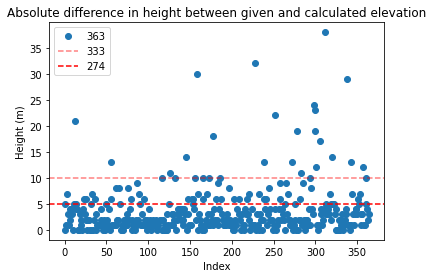

In [19]:
# Calculate some statistics
less_than_3000 = gauges_circle.query("difference_height < 3000").src_id.count()
less_than_10 = gauges_circle.query("difference_height < 10").src_id.count()
less_than_5 = gauges_circle.query("difference_height < 5").src_id.count()

# plot as points
gauges_circle.query("difference_height < 3000").difference_height.plot(style="o",label=f"{less_than_3000}")

# set labels
plt.title("Absolute difference in height between given and calculated elevation")
plt.xlabel("Index")
plt.ylabel("Height (m)")

# add lines
plt.axhline(10,color="red", linestyle="dashed",alpha=0.5,label=f"{less_than_10}")
plt.axhline(5,color="red", linestyle="dashed",alpha=1,label=f"{less_than_5}")
plt.legend();

#### Having computed the height from the raster and analysed, we van now get the max slope angle: 
This could be optimised further by doing just a single calculation rather than running it all 3x

In [20]:
n_px = 5
gauges_circle[f"slope_steepness_{n_px}px"] = functions.Raster_Slope_Steepness(gauges_circle, UK, n_px)\
                                                        .slope_steepness_max()

gauges_circle[f"abs_slope_steepness_{n_px}px"] = functions.Raster_Slope_Steepness(gauges_circle, UK, n_px)\
                                                        .slope_steepness_max_abs()

gauges_circle["dir_slope_steepness"] = functions.Raster_Slope_Steepness(gauges_circle, UK, n_px)\
                                                        .slope_steepness_max_direction()

In [21]:
gauges_circle.head(1)

,level_0,src_id,station_na,station_fi,historic_c,station_la,station_lo,station_el,first_year,last_year,raster_id,geometry,computed_height,difference_height,slope_steepness_5px,abs_slope_steepness_5px,dir_slope_steepness
0,0,00003,FAIR ISLE,fair-isle,shetland,59.526,-1.63,57,1974,2020,4,"POLYGON ((-1.60500 59.52600, -1.60512 59.52355...",57,0,14.2,14.2,nw-se


#### Can then also be saved:

In [22]:
output = ['src_id',f"slope_steepness_{n_px}px", f"abs_slope_steepness_{n_px}px"]

save = False
if save:    
    gauges_circle.to_csv(f"Slopes computed from DEM/Slopes computed from DEM_{number_px}px.csv",
                         columns=output)

### Data can be ploted as a boxplot

Text(0, 0.5, 'Steepness(%)')

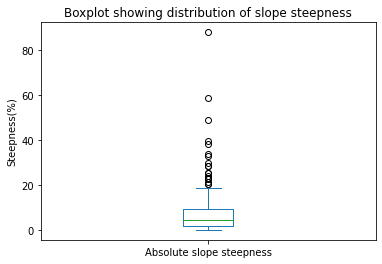

In [23]:
gauges_circle[f"abs_slope_steepness_{n_px}px"].plot(kind='box',label="Absolute slope steepness")
title = "Boxplot showing distribution of slope steepness"
plt.title(title)
plt.ylabel("Steepness(%)")
# plt.savefig(f"{title}.jpg")

### Combining all this gives the run_process:

In [24]:
def run_process(number_px, save = False):
    start = time.time()
    
    # defining inputs
    n_px = number_px
    UK = filenames[68:69] + filenames[80:83] + filenames[95:97]
    # import fresh data
    gauges_circle = gpd.read_file("circels with raster_id/circels with raster_id.shp",crs=4326)
    gauges_circle.to_crs(crs=4326,inplace=True)
    
    # only run to reset colums, trick to use the index as input
    gauges_circle.reset_index(inplace=True)
    gauges_circle.reset_index(inplace=True)
    gauges_circle.drop(columns="index",inplace=True)
    
    ## applies all previous code
    
    # using the self. functionality allows one df, list and n_px to be defined. 
    # This is stored and accessed centrally every times: saves hastle of redefining each time
    instance = functions.Raster_Slope_Steepness(gauges_circle, UK, n_px)
    
    # pre processing
    gauges_circle["computed_height"] = instance.get_raster_pixels()
    gauges_circle["difference_height"] = abs(gauges_circle.station_el - gauges_circle.computed_height)
    
    # applying the slope factors

    gauges_circle[f"slope_steepness_{n_px}px"] = instance.slope_steepness_max()

    gauges_circle[f"abs_slope_steepness_{n_px}px"] = instance.slope_steepness_max_abs()

    gauges_circle["dir_slope_steepness"] = instance.slope_steepness_max_direction()
    
    output = ['src_id',f"slope_steepness_{number_px}px", f"abs_slope_steepness_{number_px}px"]

    if save:    
        gauges_circle.to_csv(f"Slopes computed from DEM/Slopes computed from DEM_{number_px}px.csv",
                             columns=output)
    end = time.time()
    print(f'{number_px}-{(end - start)/60:.3f} min',end="\r")

## And made itterable
And to vary number_px:

In [25]:
run = False
if run:
    start_total = time.time()
    for i in range(1,2):
        print(i,end="\r")
        number_px = i
        
        run_process(number_px, save= True)
        
    end_total = time.time()
    
    print(f'{(end_total - start_total)/60:.3f} min')

#### Incase not run, we can just load the data into a df

In [26]:
number_px = 1
base = pd.read_csv(f"Slopes computed from DEM/Slopes computed from DEM_{number_px}px.csv",index_col=0,usecols=[0,1,3])

for i in range(2,31):
    number_px = i
    df = pd.read_csv(f"Slopes computed from DEM/Slopes computed from DEM_{number_px}px.csv",index_col=0,usecols=[0,1,3])
    base = base.merge(df,on="src_id")
base.head(1)

,src_id,abs_slope_steepness_1px,abs_slope_steepness_2px,abs_slope_steepness_3px,abs_slope_steepness_4px,abs_slope_steepness_5px,abs_slope_steepness_6px,abs_slope_steepness_7px,abs_slope_steepness_8px,abs_slope_steepness_9px,...,abs_slope_steepness_21px,abs_slope_steepness_22px,abs_slope_steepness_23px,abs_slope_steepness_24px,abs_slope_steepness_25px,abs_slope_steepness_26px,abs_slope_steepness_27px,abs_slope_steepness_28px,abs_slope_steepness_29px,abs_slope_steepness_30px
0,3,4.26,11.36,17.46,17.04,14.2,12.97,11.63,11.26,12.21,...,9.21,9.25,9.94,10.7,10.48,9.39,7.99,7.01,6.19,6.19


### And plot the data

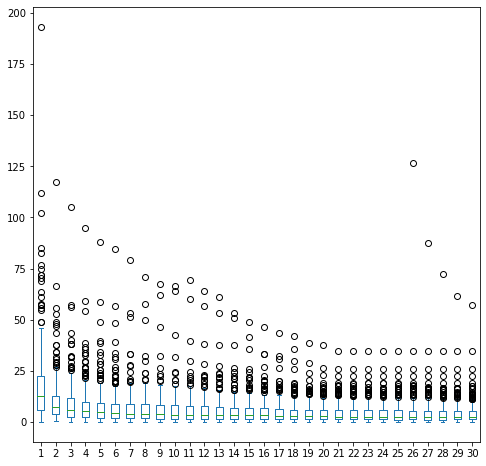

In [27]:
fig,ax = plt.subplots(1,figsize=(8,8))
base.drop(columns=["src_id"]).plot.box(ax=ax);
ax.xaxis.set_ticklabels(range(1,31));
# ax.set_ylim((-0.5,25))
# ax.figure.savefig("Figures/Comparing runs with varying pixels widths.jpg");

In [28]:
small_base = base[['src_id', 'abs_slope_steepness_1px', 'abs_slope_steepness_2px',
       'abs_slope_steepness_3px', 'abs_slope_steepness_4px',
       'abs_slope_steepness_5px']]

#### Some other exploritory plotting

<Figure size 720x72000 with 0 Axes>

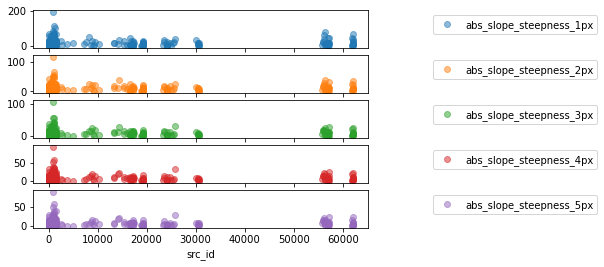

In [29]:
plt.figure(figsize=(10,1000))
ax = small_base.plot("src_id",style="o",alpha=0.5,subplots=True,sharex=True)
for i, axes in enumerate(ax):
    ax[i].legend(bbox_to_anchor=(1.7,1))

# Plotting stations:

In [30]:
n_px = 10
UK = filenames[68:69] + filenames[80:83] + filenames[95:97]
instance = functions.Raster_Slope_Steepness(gauges_circle, UK, n_px)

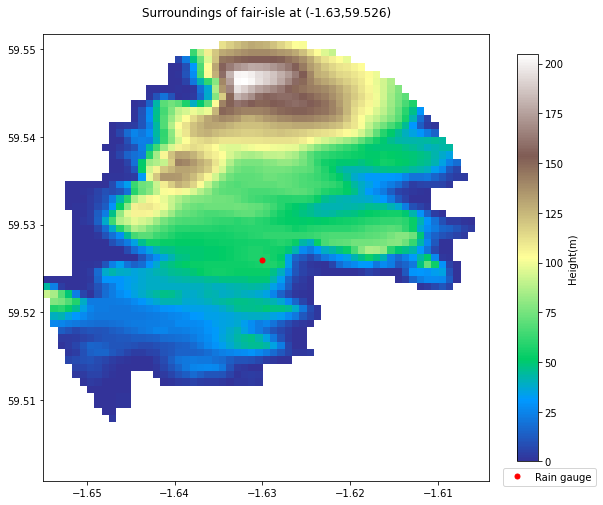

In [31]:
instance.plot_cropped_raster(0, plot_hist=False, zoom_in=False, save=False)

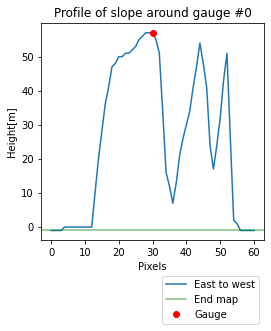

In [32]:
instance.plot_gauge(0, kind="ew", clip=True, save=False)

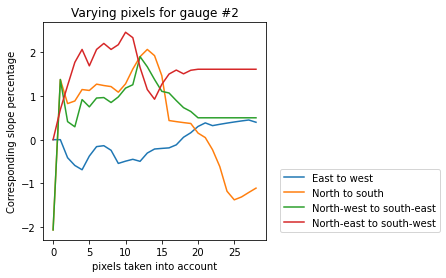

In [33]:
instance.plot_varying_n_px([2],subplots=True,save=False)

Output to be used in the next notebook

In [34]:
# gauges

In [35]:
gauges.to_file("Gauge Data/ Gauges-with-raster-id")

C:\Users\david\anaconda3\envs\python-gis\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
